In [1]:

from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO,SAC
from sogym.mmc_optim import run_mmc
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cpu


---
### Environment test and visualization:

In [2]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [3]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='image',vol_constraint_type='soft',resolution=50,check_connectivity = False)
eval_env = sogym(mode='test',observation_type='image',vol_constraint_type='soft',resolution=50)

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Volume:  0.1710482932844778
Reward  0.021039713549507854


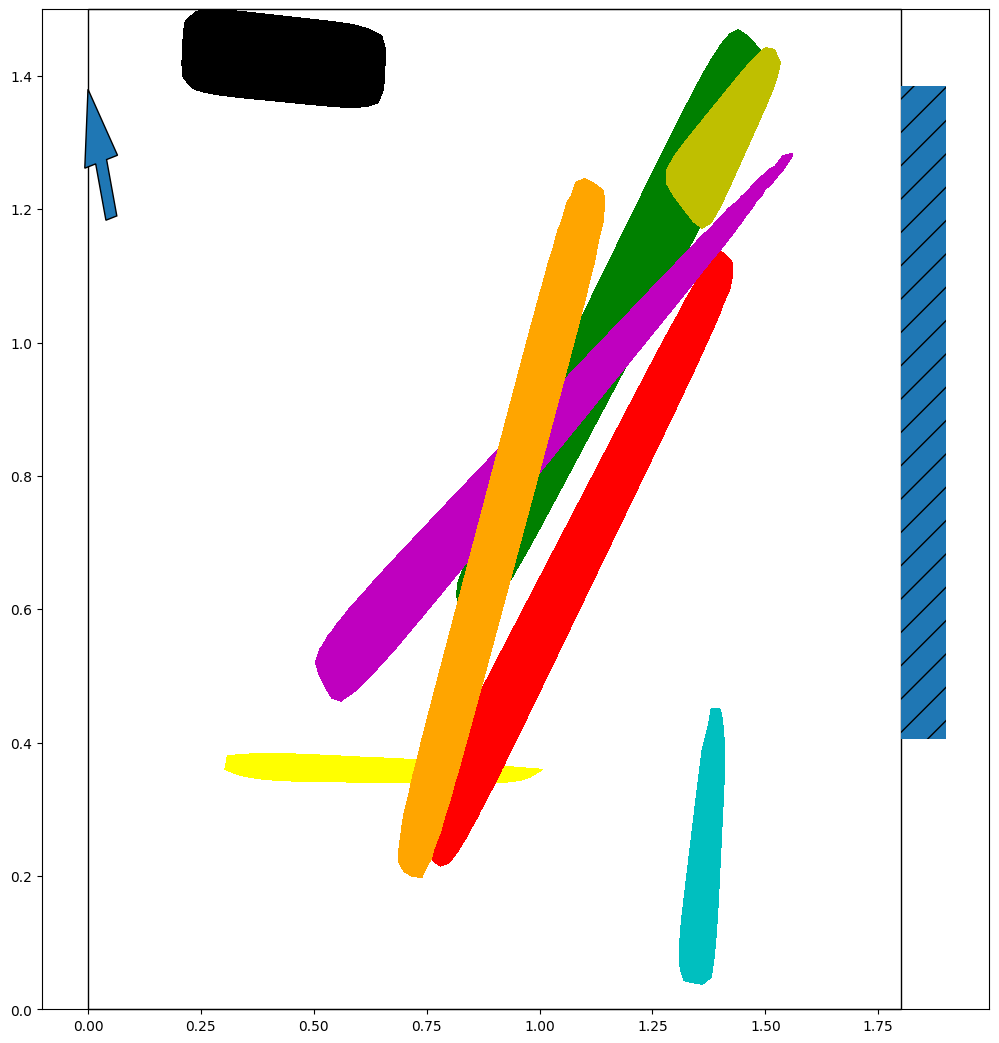

In [4]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [38]:
from sogym.utils import profile_and_analyze
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

,Full Function Path,ncalls,tottime,percall (tottime),cumtime,percall (cumtime)
646,/Users/thomasrochefort/Documents/GitHub/sogym_...,1,0.003710,3.709780e-03,57.731577,5.773158e+01
285,/Users/thomasrochefort/Documents/GitHub/sogym_...,160,0.075674,4.729597e-04,55.099848,3.443740e-01
286,/Users/thomasrochefort/Documents/GitHub/sogym_...,160,0.073309,4.581840e-04,27.403219,1.712701e-01
1333,/Users/thomasrochefort/Documents/GitHub/sogym_...,160,0.323620,2.022627e-03,27.253278,1.703330e-01
289,/Users/thomasrochefort/Documents/GitHub/sogym_...,160,0.008256,5.159688e-05,25.716929,1.607308e-01
...,...,...,...,...,...,...
14,~:0(<method 'values' of 'dict' objects>),84536,0.016200,1.916291e-07,0.016232,1.920101e-07
355,/Users/thomasrochefort/opt/anaconda3/envs/sb3/...,1600,0.000297,1.854656e-07,0.000297,1.854656e-07
34,~:0(<built-in method builtins.callable>),159730,0.028860,1.806791e-07,0.028860,1.806791e-07
2,~:0(<method 'append' of 'list' objects>),301458,0.053050,1.759777e-07,0.053050,1.759777e-07


---
### Multiprocessing

In [52]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [53]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList
from sogym.utils import FigureRecorderCallback
from stable_baselines3.common.callbacks import CheckpointCallback

# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=1000,
  save_path="./checkpoints/",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False,verbose=0)
callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         FigureRecorderCallback(check_freq=2*4*32)])

--- 
### Defining the model

In [54]:
import yaml
from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

# Load the YAML file
with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "PPO"  # or "TD3"
algorithm_params = config[algorithm_name]

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,policy = chosen_policy, device=device, **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, policy = chosen_policy, device = device, **algorithm_params)
elif algorithm_name == "TD3":

    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,policy =chosen_policy, action_noise=action_noise,device=device, **algorithm_params)


--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [55]:
#model = SAC.load("model_saved_march15",env =env) #Saved model is with soft volume constraint and 75 r
#model.set_parameters("model_saved_march15")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,callback=callback_list,tb_log_name='test_march22')
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.8/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_check_nan.VecCheckNan object at 0x7f9f09472ac0> != <stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f9ee54bcd30>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.plot to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.plot` for environment variables or `env.get_wrapper_attr('plot')` that will search the reminding wrappers.
  logger.warn(
/Users/thomasrochefort/opt/anaconda3/envs/sb3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.plot to get variables from other wrappers i

KeyboardInterrupt: 

---
### Let's visualize the agent's performance:

In [ ]:
env=sogym(mode='train',observation_type='dense',vol_constraint_type='hard' ,resolution = 500)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

In [ ]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    # print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')